# Тема: Задача оттока: варианты постановки, возможные способы решения

In [24]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgbm
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix, plot_confusion_matrix


from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
df = pd.read_csv("data/5_web/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [4]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))])
    final_transformers.append((cont_col, cont_transformer))

In [12]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [62]:
model_rf = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state = 42))])


model_rf.fit(X_train, y_train)
preds_rf = model_rf.predict_proba(X_test)[:, 1]

In [63]:
model_lr = Pipeline([
    ('features', feats),
    ('standard', StandardScaler()),
    ('classifier', LogisticRegression(random_state = 42))])

model_lr.fit(X_train, y_train)
preds_lr = model_lr.predict_proba(X_test)[:, 1]

In [64]:
model_xgb = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state = 42))])

model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict_proba(X_test)[:, 1]

[18:04:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [65]:
model_lgbm = Pipeline([
    ('features', feats),
    ('classifier', lgbm.LGBMClassifier(random_state = 42))])

model_lgbm.fit(X_train, y_train)
preds_lgbm = model_lgbm.predict_proba(X_test)[:, 1]

In [66]:
dict_model = {'model_rf': preds_rf, 
              'model_lr': preds_lr, 
              'model_xgb': preds_xgb, 
              'model_lgbm': preds_lgbm}

### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [67]:
def get_metrics(probs, model=None):
    
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = round(roc_auc_score(y_test, probs), 3)
    
    ix = np.argmax(fscore)
    print('%s - Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (model,
                                                                            thresholds[ix], fscore[ix],
                                                                            precision[ix], recall[ix],
                                                                            roc_auc))
    
    return thresholds[ix]

In [68]:
for k, v in dict_model.items():
    get_metrics(v, k)

model_rf - Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629, Roc-AUC=0.864
model_lr - Best Threshold=0.287286, F-Score=0.510, Precision=0.460, Recall=0.572, Roc-AUC=0.772
model_xgb - Best Threshold=0.373318, F-Score=0.626, Precision=0.619, Recall=0.633, Roc-AUC=0.861
model_lgbm - Best Threshold=0.353268, F-Score=0.648, Precision=0.630, Recall=0.668, Roc-AUC=0.873


* В данном примере более подходящяя метрика - precision.  
* Соответственно лучшая модель - RandomForestClassifier

model_rf - Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629, Roc-AUC=0.864
Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


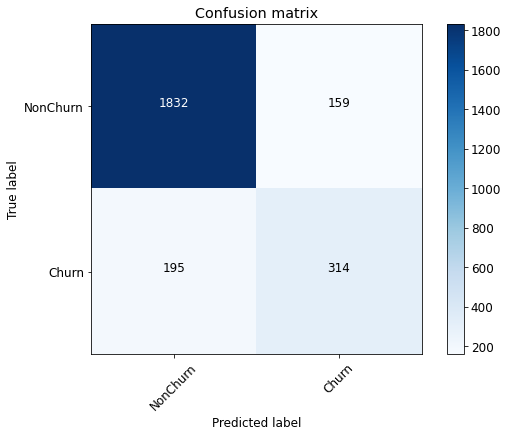

In [69]:
thresholds = get_metrics(preds_rf, 'model_rf')

plt.figure(figsize=(8, 6))
font = {'size' : 12}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_rf>thresholds)
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.show()

### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 

In [70]:
for k, v in dict_model.items():
    
    precision, recall, thresholds = precision_recall_curve(y_test, v)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    
    cnf_matrix = confusion_matrix(y_test, v>thresholds[ix])
    
    inc = (cnf_matrix[0][0] + cnf_matrix[1][0])*2
    exp = cnf_matrix[1][0] + cnf_matrix[1][1]
    result = inc - exp
    if result > 0:
        print(f'Прибыль модели {k} = {result}$')
    else:
        print(f'Убыток модели {k} = {result}$')

Прибыль модели model_rf = 3545$
Прибыль модели model_lr = 3227$
Прибыль модели model_xgb = 3453$
Прибыль модели model_lgbm = 3413$


### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [77]:
params={
        'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__n_estimators':[50, 100, 150],
        'classifier__max_depth':[None]
        }

In [79]:
grid = GridSearchCV(model_rf,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.3,
 'classifier__n_estimators': 100}

In [83]:
model = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(max_features=0.3,
                                        n_estimators=100,
                                        max_depth=None,
                                        class_weight={0: 1, 1: 4},
                                        random_state=42))])


model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1]

None - Best Threshold=0.430000, F-Score=0.644, Precision=0.714, Recall=0.587, Roc-AUC=0.863
Confusion matrix, without normalization
[[1876  115]
 [ 216  293]]


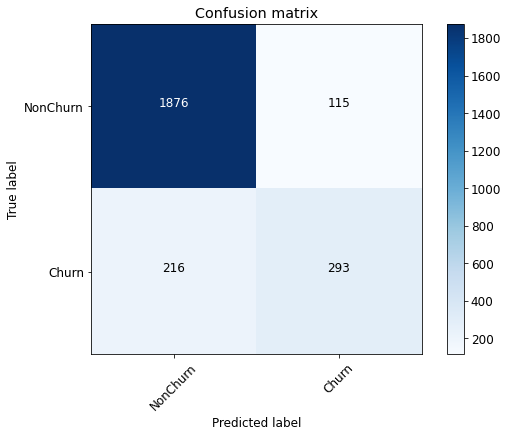

In [84]:
thresholds = get_metrics(preds)

plt.figure(figsize=(8, 6))
font = {'size' : 12}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds)
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.show()

### 5. (опционально) Еще раз провести оценку экономической эффективности

In [85]:
inc = (cnf_matrix[0][0] + cnf_matrix[1][0])*2
exp = cnf_matrix[1][0] + cnf_matrix[1][1]
result = inc - exp
if result > 0:
    print(f'Прибыль модели {k} = {result}$')
else:
    print(f'Убыток модели {k} = {result}$')

Прибыль модели model_lgbm = 3675$
